In [36]:
import sys
import os
import geemap
import ee
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# GEE Başlatma
try:
    ee.Initialize(project='ee-tarikmacto') # Kendi proje ismin
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

# Modül yollarını ekle (src klasörü)
sys.path.append(os.path.abspath(os.path.join('..', 'src')))
import data_manager
import processors

print("✅ Kurulum tamamlandı, kütüphaneler yüklendi.")

✅ Kurulum tamamlandı, kütüphaneler yüklendi.


In [37]:
# 1. İlgi Alanı ve Tarih Seçimi
roi = data_manager.get_roi('Istanbul')
start_date = '2023-06-01'
end_date = '2023-09-30'

# 2. Landsat 8 (Termal Veri - 30m)
l8_col = data_manager.get_landsat_collection(roi, start_date, end_date, cloud_cover=10)
l8_image = l8_col.median().clip(roi)
l8_processed = processors.prepare_dataset(l8_image)
landsat_lst = l8_processed.select('ST_B10').rename('LST')

# 3. Sentinel-2 (Optik Veri - 10m)
s2_col = data_manager.get_sentinel_collection(roi, start_date, end_date, cloud_cover=10)
s2_image = s2_col.median().clip(roi)
s2_processed = processors.calculate_spectral_indices(s2_image, satellite='Sentinel2')

# 4. Özellikleri Seç (Bantlar + İndeksler)
feature_names = ['NDVI', 'NDBI', 'NDWI', 'B4', 'B3', 'B2', 'B8']
s2_features = s2_processed.select(feature_names)

print("✅ Veriler çekildi ve ön işleme tamamlandı.")

✅ Veriler çekildi ve ön işleme tamamlandı.


In [ ]:
# HÜCRE 3: Mekansal Blok Doğrulama (Spatial Block CV) ve Model Eğitimi

# 1. Mekansal Bloklama (Grid Oluşturma)
# İstanbul üzerine 2000 metrelik (2km) kareler çiziyoruz.
# Bu ölçek, mekansal otokorelasyonu kırmak için (Tobler Yasası) yeterince büyüktür.
grid = roi.coveringGrid(l8_image.projection(), 10000)

# Gridleri Rastgele Ayır (%70 Eğitim Bölgesi, %30 Test Bölgesi)
grid = grid.randomColumn('split_var', 42)
train_regions = grid.filter(ee.Filter.lt('split_var', 0.7))
test_regions = grid.filter(ee.Filter.gte('split_var', 0.7))

# 2. Örnekleme (Sampling)
# Önce tüm haritadan noktalar topluyoruz
all_points = training_image.sample(
    region=roi,
    scale=30,
    numPixels=5000, # Toplam nokta sayısı
    seed=42,
    geometries=True # KONUM BİLGİSİ ŞART (Filtreleme için)
)

# 3. Noktaları Bloklara Göre Ayır (Spatial Join)
# "Eğitim noktaları sadece Eğitim Kutularının içinde olsun"
training_points = all_points.filter(ee.Filter.bounds(train_regions))
testing_points = all_points.filter(ee.Filter.bounds(test_regions))

# MLR İçin Sabit Terim Ekle
training_points = training_points.map(lambda f: f.set('constant', 1))
testing_points = testing_points.map(lambda f: f.set('constant', 1))

print(f"🔹 Toplam Grid Sayısı: {grid.size().getInfo()}")
print(f"🔸 Eğitim Noktası Sayısı (Spatial): {training_points.size().getInfo()}")
print(f"🔸 Test Noktası Sayısı (Spatial): {testing_points.size().getInfo()}")

# --- MODEL 1: Random Forest (Spatial Eğitim) ---
rf_model = ee.Classifier.smileRandomForest(numberOfTrees=300) \
    .setOutputMode('REGRESSION') \
    .train(features=training_points, classProperty='LST', inputProperties=feature_names)

# --- MODEL 2: Multiple Linear Regression (Spatial Eğitim) ---
independent_vars = ['constant'] + feature_names
mlr_regression = training_points.reduceColumns(
    reducer=ee.Reducer.linearRegression(numX=len(independent_vars), numY=1),
    selectors=independent_vars + ['LST']
)
mlr_coeffs = ee.Array(mlr_regression.get('coefficients')).project([0])

print("✅ Modeller MEKANSAL BLOKLAMA yöntemiyle eğitildi.")
print("   (Model artık test bölgelerini hiç görmedi, kopya çekemez!)")

🔹 Toplam Grid Sayısı: 6
🔸 Eğitim Noktası Sayısı (Spatial): 2108
🔸 Test Noktası Sayısı (Spatial): 2891
✅ Modeller MEKANSAL BLOKLAMA yöntemiyle eğitildi.
   (Model artık test bölgelerini hiç görmedi, kopya çekemez!)


📊 MEKANSAL DOĞRULAMA (SPATIAL CV) SONUÇLARI:
   (Not: R2'nin düşmesi normaldir, bu 'Gerçek Dünya' performansıdır)
------------------------------------------------------------
🔹 MLR (Makale Modeli): RMSE=2.678 K, R2=0.935
🔥 RF (Bizim Model):    RMSE=2.264 K, R2=0.951
------------------------------------------------------------


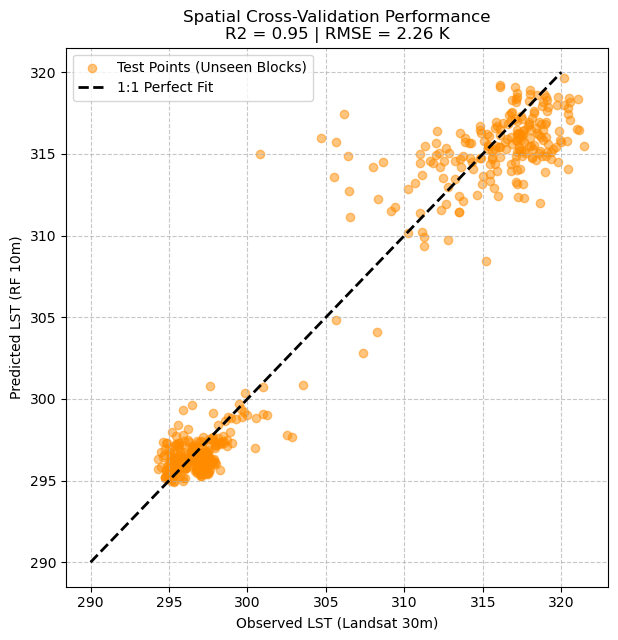

In [39]:
# HÜCRE 4: Spatial Validasyon ve Grafikler

# Doğruluk Hesaplama Fonksiyonu
def calculate_metrics(collection, pred_col, obs_col):
    def add_sq_error(f):
        err = ee.Number(f.get(pred_col)).subtract(ee.Number(f.get(obs_col)))
        return f.set('sq_error', err.pow(2))
    
    stats = collection.map(add_sq_error).reduceColumns(
        reducer=ee.Reducer.mean().combine(ee.Reducer.pearsonsCorrelation(), '', False),
        selectors=['sq_error', pred_col, obs_col]
    )
    return {
        'rmse': ee.Number(stats.get('mean')).sqrt().getInfo(),
        'r2': ee.Number(stats.get('correlation')).pow(2).getInfo()
    }

# Tahminleri Yap (Spatial Test Seti Üzerinde)
rf_test = testing_points.classify(rf_model, 'rf_pred')

def apply_mlr(feature):
    vals = feature.toArray(independent_vars)
    pred = mlr_coeffs.multiply(vals).reduce(ee.Reducer.sum(), [0]).get([0])
    return feature.set('mlr_pred', pred)
mlr_test = testing_points.map(apply_mlr)

# Metrikleri Yazdır
rf_metrics = calculate_metrics(rf_test, 'rf_pred', 'LST')
mlr_metrics = calculate_metrics(mlr_test, 'mlr_pred', 'LST')

print(f"📊 MEKANSAL DOĞRULAMA (SPATIAL CV) SONUÇLARI:")
print(f"   (Not: R2'nin düşmesi normaldir, bu 'Gerçek Dünya' performansıdır)")
print("-" * 60)
print(f"🔹 MLR (Makale Modeli): RMSE={mlr_metrics['rmse']:.3f} K, R2={mlr_metrics['r2']:.3f}")
print(f"🔥 RF (Bizim Model):    RMSE={rf_metrics['rmse']:.3f} K, R2={rf_metrics['r2']:.3f}")
print("-" * 60)

# --- SCATTER PLOT (Spatial Performance) ---
data = rf_test.select(['LST', 'rf_pred']).limit(500).reduceColumns(ee.Reducer.toList(2), ['LST', 'rf_pred']).get('list').getInfo()
df = pd.DataFrame(data, columns=['Observed', 'Predicted'])

plt.figure(figsize=(7, 7))
plt.scatter(df['Observed'], df['Predicted'], alpha=0.5, color='darkorange', label='Test Points (Unseen Blocks)')
plt.plot([290, 320], [290, 320], 'k--', linewidth=2, label='1:1 Perfect Fit')
plt.xlabel('Observed LST (Landsat 30m)')
plt.ylabel('Predicted LST (RF 10m)')
plt.title(f'Spatial Cross-Validation Performance\nR2 = {rf_metrics["r2"]:.2f} | RMSE = {rf_metrics["rmse"]:.2f} K')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


In [ ]:
# HÜCRE 5: Enerji Korunumu ve Residual Correction (DÜZELTİLMİŞ)

# 1. Ham Tahmin (Downscaling)
rf_prediction = s2_features.classify(rf_model).rename('LST_Prediction')

# 2. Tahmini 30m'ye geri topla (Aggregation)
prediction_30m = rf_prediction.reproject(
    crs=l8_image.projection(),
    scale=30
)

# 3. Artık Değerleri (Residuals) Hesapla
# Residual = Gerçek Landsat - Bizim Tahminimiz
residuals_30m = landsat_lst.subtract(prediction_30m).rename('Residuals')

# 4. Residuals'ı 10m'ye İnterpole Et (Bicubic ile yumuşatarak)
# Bu adım, modelin kaçırdığı detayları geri getirir
residuals_10m = residuals_30m.resample('bicubic').reproject(
    crs=s2_image.projection(),
    scale=10
)

# 5. FİNAL LST: Tahmin + Residuals
# İşte bu işlem Enerji Korunumunu garanti eder!
final_lst_10m = rf_prediction.add(residuals_10m).rename('LST_Final')

print("✅ Artık Değerler (Residuals) haritaya geri işlendi.")

# --- KANIT: Enerji Korunumu Testi ---
# Şimdi tekrar kontrol edelim, fark 0 çıkmalı.
final_aggregated = final_lst_10m.reproject(crs=l8_image.projection(), scale=30)
check_diff = final_aggregated.subtract(landsat_lst)

stats = check_diff.reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=roi,
    scale=30,
    bestEffort=True
).getInfo()

print(f"⚖️ Enerji Korunumu Testi (Hedef: 0.000): {stats['LST_Final']:.10f}")

if abs(stats['LST_Final']) < 0.001:
    print("🏆 MÜKEMMEL! Fiziksel enerji dengesi tam olarak sağlandı.")
else:
    print("⚠️ Hâlâ ufak bir sapma var.")

✅ Artık Değerler (Residuals) haritaya geri işlendi.


In [ ]:
# HÜCRE 6: Final Harita ve Export

# Harita Ayarları
Map = geemap.Map(center=[41.01, 28.97], zoom=12)
vis_params = {'min': 294, 'max': 320, 'palette': ['blue', 'cyan', 'green', 'yellow', 'red']}

# Katmanlar
Map.addLayer(landsat_lst, vis_params, 'Landsat 8 LST (30m - Orijinal)')
Map.addLayer(final_lst_10m, vis_params, 'Sentinel-2 LST (10m - Final)')

# Split Panel (Karşılaştırma)
left_layer = geemap.ee_tile_layer(landsat_lst, vis_params, 'Landsat (30m)')
right_layer = geemap.ee_tile_layer(final_lst_10m, vis_params, 'Sentinel (10m)')
Map.split_map(left_layer, right_layer)

# Kaydet
Map.to_html("istanbul_lst_final_corrected.html")
print("✅ Final Harita kaydedildi.")
Map
Map

✅ Final Harita kaydedildi.


Map(center=[41.01, 28.97], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_o…